In [1]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Define the calculate_var function
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.

    Parameters:
    - frequency_lambda (float): The mean rate of events (λ) for Poisson distribution.
    - severity_shape (float): The shape parameter for log-normal distribution.
    - severity_scale (float): The scale parameter for log-normal distribution.
    - severity_loc (float): The location parameter for log-normal distribution.
    - confidence_level (float): Confidence level for VaR (default is 0.999).
    - n_simulations (int): Number of Monte Carlo simulations (default is 10000).

    Returns:
    - float: The calculated VaR at the specified confidence level.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value

# Load the operational risk dataset
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Group by year, business line, and event type
grouped = df.groupby(['Year', 'Business Line', 'Event Type'])

# Initialize a list to hold the results
results = []

# Iterate over each group
for (year, business_line, event_type), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Calculate VaR for net loss and event count
    var_net_loss = calculate_var(total_event_count, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    var_event_count = np.percentile(poisson.rvs(mu=total_event_count, size=10000), 99.9)  # Poisson VaR for event count

    # Append the results
    results.append({
        'Year': year,
        'Business Line': business_line,
        'Event Type': event_type,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Show the results
print(result_df)

    Year      Business Line       Event Type  Total Net Loss  \
0   2020  Corporate Banking       Compliance      1178440.66   
1   2020  Corporate Banking            Fraud      1044400.43   
2   2020  Corporate Banking  Physical Damage       720221.69   
3   2020  Corporate Banking   System Failure      1043377.98   
4   2020          Insurance       Compliance      1355431.31   
..   ...                ...              ...             ...   
75  2024     Retail Banking   System Failure      5120518.30   
76  2024  Wealth Management       Compliance      5624138.76   
77  2024  Wealth Management            Fraud      5408901.57   
78  2024  Wealth Management  Physical Damage      5866408.19   
79  2024  Wealth Management   System Failure      5711744.98   

    Total Event Count  VaR Net Loss  VaR Event Count  
0                  44  1.299636e+07           65.000  
1                  43  7.043111e+06           65.000  
2                  25  6.775743e+06           43.000  
3          

In [2]:
result_df

,Year,Business Line,Event Type,Total Net Loss,Total Event Count,VaR Net Loss,VaR Event Count
0,2020,Corporate Banking,Compliance,1178440.66,44,1.299636e+07,65.000
1,2020,Corporate Banking,Fraud,1044400.43,43,7.043111e+06,65.000
2,2020,Corporate Banking,Physical Damage,720221.69,25,6.775743e+06,43.000
3,2020,Corporate Banking,System Failure,1043377.98,40,9.575177e+06,61.001
4,2020,Insurance,Compliance,1355431.31,51,1.553352e+07,74.000
...,...,...,...,...,...,...,...
75,2024,Retail Banking,System Failure,5120518.30,203,4.254348e+07,246.000
76,2024,Wealth Management,Compliance,5624138.76,206,6.030275e+07,251.001
77,2024,Wealth Management,Fraud,5408901.57,217,4.953413e+07,264.001
78,2024,Wealth Management,Physical Damage,5866408.19,218,6.108046e+07,263.001


In [3]:
# Calculate summary statistics for 'Total Net Loss' and 'VaR Net Loss'
metrics = ['Total Net Loss', 'VaR Net Loss']
outlier_results = []

for metric in metrics:
    # Calculate Q1, Q3, and IQR
    Q1 = result_df[metric].quantile(0.25)
    Q3 = result_df[metric].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Flag rows as outliers for the current metric
    result_df[f'{metric} Outlier'] = (result_df[metric] < lower_bound) | (result_df[metric] > upper_bound)
    
    # Append outlier details to the results
    outlier_results.append({
        'Metric': metric,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': result_df[f'{metric} Outlier'].sum()
    })

# Convert outlier details to a DataFrame for summary
outlier_summary = pd.DataFrame(outlier_results)

# Filter rows that are outliers for any metric
outliers = result_df[result_df['Total Net Loss Outlier'] | result_df['VaR Net Loss Outlier']]

# Display the summary of outliers
print(outlier_summary)

# Display the rows flagged as outliers
print(outliers)


           Metric   Lower Bound   Upper Bound  Outliers Count
0  Total Net Loss  3.602035e+06  8.201126e+06              16
1    VaR Net Loss  2.158199e+07  8.689621e+07              16
    Year      Business Line       Event Type  Total Net Loss  \
0   2020  Corporate Banking       Compliance      1178440.66   
1   2020  Corporate Banking            Fraud      1044400.43   
2   2020  Corporate Banking  Physical Damage       720221.69   
3   2020  Corporate Banking   System Failure      1043377.98   
4   2020          Insurance       Compliance      1355431.31   
5   2020          Insurance            Fraud       839500.25   
6   2020          Insurance  Physical Damage       833369.87   
7   2020          Insurance   System Failure      1164394.40   
8   2020     Retail Banking       Compliance       719252.98   
9   2020     Retail Banking            Fraud      1061984.35   
10  2020     Retail Banking  Physical Damage       732694.73   
11  2020     Retail Banking   System Failure  

           Metric   Lower Bound   Upper Bound  Outliers Count
0  Total Net Loss  3.602035e+06  8.201126e+06              16
1    VaR Net Loss  2.269857e+07  9.018169e+07              16
    Year      Business Line       Event Type  Total Net Loss  \
0   2020  Corporate Banking       Compliance      1178440.66   
1   2020  Corporate Banking            Fraud      1044400.43   
2   2020  Corporate Banking  Physical Damage       720221.69   
3   2020  Corporate Banking   System Failure      1043377.98   
4   2020          Insurance       Compliance      1355431.31   
5   2020          Insurance            Fraud       839500.25   
6   2020          Insurance  Physical Damage       833369.87   
7   2020          Insurance   System Failure      1164394.40   
8   2020     Retail Banking       Compliance       719252.98   
9   2020     Retail Banking            Fraud      1061984.35   
10  2020     Retail Banking  Physical Damage       732694.73   
11  2020     Retail Banking   System Failure  

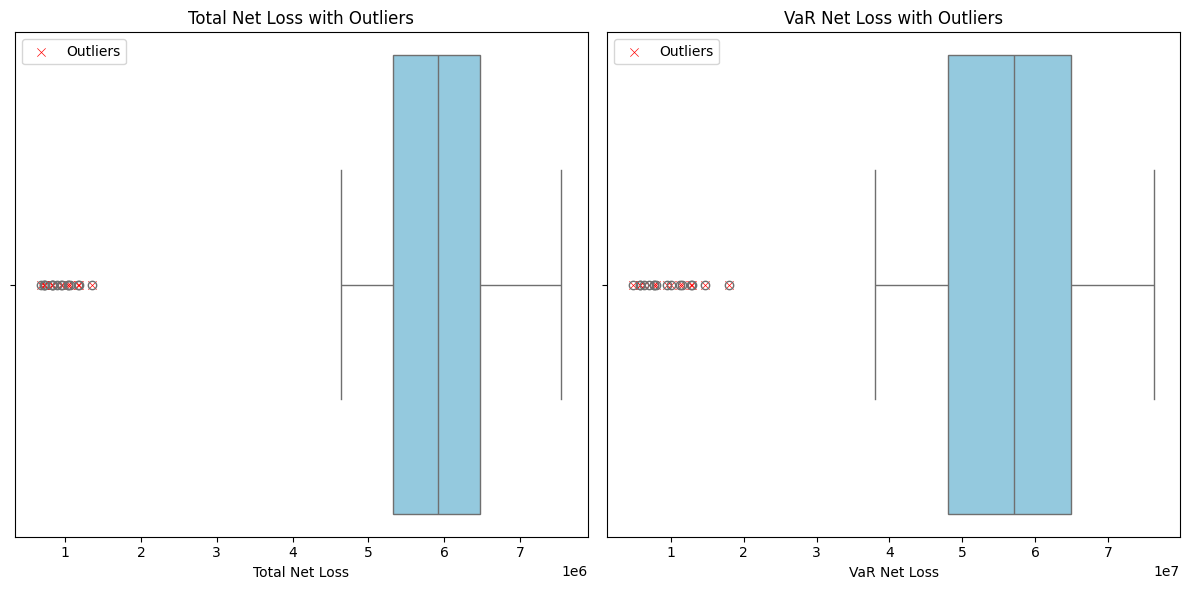

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'result_df' is already populated with your data
metrics = ['Total Net Loss', 'VaR Net Loss']
outlier_results = []

# Initialize the plot
plt.figure(figsize=(12, 6))

# Iterate through the metrics to detect outliers and plot them
for metric in metrics:
    # Calculate Q1, Q3, and IQR
    Q1 = result_df[metric].quantile(0.25)
    Q3 = result_df[metric].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Flag rows as outliers for the current metric
    result_df[f'{metric} Outlier'] = (result_df[metric] < lower_bound) | (result_df[metric] > upper_bound)
    
    # Append outlier details to the results
    outlier_results.append({
        'Metric': metric,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': result_df[f'{metric} Outlier'].sum()
    })
    
    # Plotting the data with outliers highlighted
    plt.subplot(1, 2, metrics.index(metric) + 1)
    sns.boxplot(data=result_df, x=metric, color='skyblue')
    sns.scatterplot(data=result_df[result_df[f'{metric} Outlier']], x=metric, 
                    y=[0] * result_df[result_df[f'{metric} Outlier']].shape[0], 
                    color='red', label='Outliers', marker='x')
    plt.title(f'{metric} with Outliers')
    plt.xlabel(metric)

# Convert outlier details to a DataFrame for summary
outlier_summary = pd.DataFrame(outlier_results)

# Filter rows that are outliers for any metric
outliers = result_df[result_df['Total Net Loss Outlier'] | result_df['VaR Net Loss Outlier']]

# Display the summary of outliers
print(outlier_summary)

# Display the rows flagged as outliers
print(outliers)

# Show the plots
plt.tight_layout()
plt.show()


           Metric   Lower Bound   Upper Bound  Outliers Count
0  Total Net Loss  3.602035e+06  8.201126e+06              16
1    VaR Net Loss  2.269857e+07  9.018169e+07              16
    Year      Business Line       Event Type  Total Net Loss  \
0   2020  Corporate Banking       Compliance      1178440.66   
1   2020  Corporate Banking            Fraud      1044400.43   
2   2020  Corporate Banking  Physical Damage       720221.69   
3   2020  Corporate Banking   System Failure      1043377.98   
4   2020          Insurance       Compliance      1355431.31   
5   2020          Insurance            Fraud       839500.25   
6   2020          Insurance  Physical Damage       833369.87   
7   2020          Insurance   System Failure      1164394.40   
8   2020     Retail Banking       Compliance       719252.98   
9   2020     Retail Banking            Fraud      1061984.35   
10  2020     Retail Banking  Physical Damage       732694.73   
11  2020     Retail Banking   System Failure  

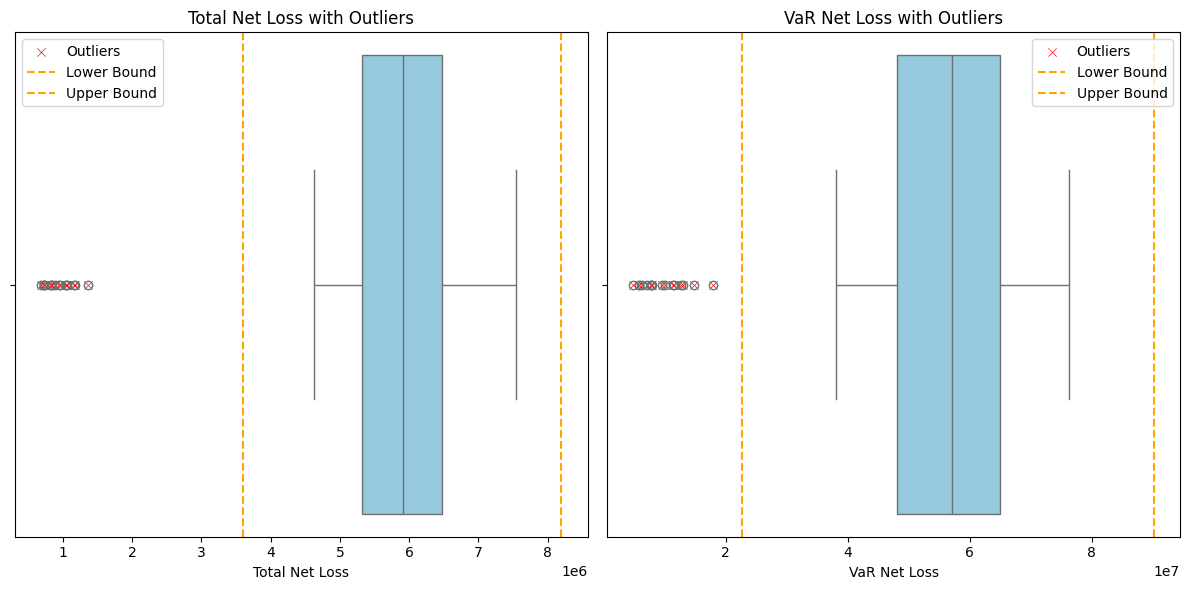

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'result_df' is already populated with your data
metrics = ['Total Net Loss', 'VaR Net Loss']
outlier_results = []

# Initialize the plot
plt.figure(figsize=(12, 6))

# Iterate through the metrics to detect outliers and plot them
for metric in metrics:
    # Calculate Q1, Q3, and IQR
    Q1 = result_df[metric].quantile(0.25)
    Q3 = result_df[metric].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Flag rows as outliers for the current metric
    result_df[f'{metric} Outlier'] = (result_df[metric] < lower_bound) | (result_df[metric] > upper_bound)
    
    # Append outlier details to the results
    outlier_results.append({
        'Metric': metric,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': result_df[f'{metric} Outlier'].sum()
    })
    
    # Plotting the data with outliers highlighted
    plt.subplot(1, 2, metrics.index(metric) + 1)
    sns.boxplot(data=result_df, x=metric, color='skyblue')
    
    # Highlight outliers
    sns.scatterplot(data=result_df[result_df[f'{metric} Outlier']], x=metric, 
                    y=[0] * result_df[result_df[f'{metric} Outlier']].shape[0], 
                    color='red', label='Outliers', marker='x')
    
    # Annotate the lower and upper bounds
    plt.axvline(lower_bound, color='orange', linestyle='--', label='Lower Bound')
    plt.axvline(upper_bound, color='orange', linestyle='--', label='Upper Bound')
    
    # Title and labels
    plt.title(f'{metric} with Outliers')
    plt.xlabel(metric)
    plt.legend()

# Convert outlier details to a DataFrame for summary
outlier_summary = pd.DataFrame(outlier_results)

# Filter rows that are outliers for any metric
outliers = result_df[result_df['Total Net Loss Outlier'] | result_df['VaR Net Loss Outlier']]

# Display the summary of outliers
print(outlier_summary)

# Display the rows flagged as outliers
print(outliers)

# Show the plots
plt.tight_layout()
plt.show()


In [4]:
outliers

,Year,Business Line,Event Type,Total Net Loss,Total Event Count,VaR Net Loss,VaR Event Count,Total Net Loss Outlier,VaR Net Loss Outlier
0,2020,Corporate Banking,Compliance,1178440.66,44,1.299636e+07,65.000,True,True
1,2020,Corporate Banking,Fraud,1044400.43,43,7.043111e+06,65.000,True,True
2,2020,Corporate Banking,Physical Damage,720221.69,25,6.775743e+06,43.000,True,True
3,2020,Corporate Banking,System Failure,1043377.98,40,9.575177e+06,61.001,True,True
4,2020,Insurance,Compliance,1355431.31,51,1.553352e+07,74.000,True,True
5,2020,Insurance,Fraud,839500.25,30,8.348572e+06,48.001,True,True
6,2020,Insurance,Physical Damage,833369.87,33,1.058691e+07,53.001,True,True
7,2020,Insurance,System Failure,1164394.40,41,1.531688e+07,62.000,True,True
8,2020,Retail Banking,Compliance,719252.98,36,5.035766e+06,56.000,True,True
9,2020,Retail Banking,Fraud,1061984.35,42,1.102865e+07,64.000,True,True


In [5]:
import numpy as np

# Example: Calculate e^VaR_Net_Loss
var_net_loss = 10  # Example VaR Net Loss value

# Calculate exponential of VaR Net Loss
exp_var_net_loss = np.exp(var_net_loss)

print(f"Exponential of VaR Net Loss: {exp_var_net_loss}")



Exponential of VaR Net Loss: 22026.465794806718


In [8]:
# Convert the 'VaR Net Loss' column from scientific notation to regular numbers
result_df['VaR Net Loss Regular'] = result_df['VaR Net Loss'].apply(lambda x: f"{x:.0f}")

# Display the updated DataFrame
print(result_df[['Business Line', 'Event Type', 'Year', 'VaR Net Loss', 'VaR Net Loss Regular']])



        Business Line       Event Type  Year  VaR Net Loss  \
0   Corporate Banking       Compliance  2020  1.299636e+07   
1   Corporate Banking            Fraud  2020  7.043111e+06   
2   Corporate Banking  Physical Damage  2020  6.775743e+06   
3   Corporate Banking   System Failure  2020  9.575177e+06   
4           Insurance       Compliance  2020  1.553352e+07   
..                ...              ...   ...           ...   
75     Retail Banking   System Failure  2024  4.254348e+07   
76  Wealth Management       Compliance  2024  6.030275e+07   
77  Wealth Management            Fraud  2024  4.953413e+07   
78  Wealth Management  Physical Damage  2024  6.108046e+07   
79  Wealth Management   System Failure  2024  5.235720e+07   

   VaR Net Loss Regular  
0              12996363  
1               7043111  
2               6775743  
3               9575177  
4              15533518  
..                  ...  
75             42543481  
76             60302751  
77             495341

In [9]:
result_df

,Year,Business Line,Event Type,Total Net Loss,Total Event Count,VaR Net Loss,VaR Event Count,Total Net Loss Outlier,VaR Net Loss Outlier,Exp VaR Net Loss,VaR Net Loss Regular
0,2020,Corporate Banking,Compliance,1178440.66,44,1.299636e+07,65.000,True,True,inf,12996363
1,2020,Corporate Banking,Fraud,1044400.43,43,7.043111e+06,65.000,True,True,inf,7043111
2,2020,Corporate Banking,Physical Damage,720221.69,25,6.775743e+06,43.000,True,True,inf,6775743
3,2020,Corporate Banking,System Failure,1043377.98,40,9.575177e+06,61.001,True,True,inf,9575177
4,2020,Insurance,Compliance,1355431.31,51,1.553352e+07,74.000,True,True,inf,15533518
...,...,...,...,...,...,...,...,...,...,...,...
75,2024,Retail Banking,System Failure,5120518.30,203,4.254348e+07,246.000,False,False,inf,42543481
76,2024,Wealth Management,Compliance,5624138.76,206,6.030275e+07,251.001,False,False,inf,60302751
77,2024,Wealth Management,Fraud,5408901.57,217,4.953413e+07,264.001,False,False,inf,49534134
78,2024,Wealth Management,Physical Damage,5866408.19,218,6.108046e+07,263.001,False,False,inf,61080456


In [10]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Define the calculate_var function
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value

# Load the operational risk dataset
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Group by year, business line, and event type
grouped = df.groupby(['Year', 'Business Line', 'Event Type'])

# Initialize a list to hold the results
results = []

# Iterate over each group
for (year, business_line, event_type), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Calculate VaR for net loss and event count for this year
    var_net_loss = calculate_var(total_event_count, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    var_event_count = np.percentile(poisson.rvs(mu=total_event_count, size=10000), 99.9)  # Poisson VaR for event count

    # Append the results
    results.append({
        'Year': year,
        'Business Line': business_line,
        'Event Type': event_type,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Predict next year's VaR (for example, 2022) based on historical trends
predicted_results = []

# Loop through the historical data to predict next year's VaR
for (business_line, event_type), group in result_df.groupby(['Business Line', 'Event Type']):
    # For each business line and event type, calculate the mean and standard deviation of the event count and net loss
    mean_event_count = group['Total Event Count'].mean()
    std_event_count = group['Total Event Count'].std()
    mean_net_loss = group['Total Net Loss'].mean()
    std_net_loss = group['Total Net Loss'].std()
    
    # Simulate next year's event count and net loss (assuming same distribution behavior)
    simulated_event_counts = poisson.rvs(mu=mean_event_count, size=10000)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=10000)
    
    # Predict VaR for next year
    var_net_loss_next_year = np.percentile(simulated_event_counts * simulated_loss_amounts, 99.9)
    var_event_count_next_year = np.percentile(simulated_event_counts, 99.9)
    
    predicted_results.append({
        'Year': 2022,  # Predicting for 2022
        'Business Line': business_line,
        'Event Type': event_type,
        'Predicted VaR Net Loss': var_net_loss_next_year,
        'Predicted VaR Event Count': var_event_count_next_year
    })

# Convert the predicted results to a DataFrame
predicted_df = pd.DataFrame(predicted_results)

# Show the predicted results
print(predicted_df)


    Year      Business Line       Event Type  Predicted VaR Net Loss  \
0   2022  Corporate Banking       Compliance            5.647299e+07   
1   2022  Corporate Banking            Fraud            5.504514e+07   
2   2022  Corporate Banking  Physical Damage            4.837054e+07   
3   2022  Corporate Banking   System Failure            5.650924e+07   
4   2022          Insurance       Compliance            5.141347e+07   
5   2022          Insurance            Fraud            4.918959e+07   
6   2022          Insurance  Physical Damage            4.643252e+07   
7   2022          Insurance   System Failure            4.967677e+07   
8   2022     Retail Banking       Compliance            4.664370e+07   
9   2022     Retail Banking            Fraud            4.382973e+07   
10  2022     Retail Banking  Physical Damage            5.244796e+07   
11  2022     Retail Banking   System Failure            5.357562e+07   
12  2022  Wealth Management       Compliance            6.166539

In [11]:
predicted_df

,Year,Business Line,Event Type,Predicted VaR Net Loss,Predicted VaR Event Count
0,2022,Corporate Banking,Compliance,5.647299e+07,244.001
1,2022,Corporate Banking,Fraud,5.504514e+07,244.000
2,2022,Corporate Banking,Physical Damage,4.837054e+07,245.000
3,2022,Corporate Banking,System Failure,5.650924e+07,252.002
4,2022,Insurance,Compliance,5.141347e+07,238.000
5,2022,Insurance,Fraud,4.918959e+07,235.001
6,2022,Insurance,Physical Damage,4.643252e+07,247.000
7,2022,Insurance,System Failure,4.967677e+07,246.001
8,2022,Retail Banking,Compliance,4.664370e+07,238.001
9,2022,Retail Banking,Fraud,4.382973e+07,248.000


In [12]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Define the calculate_var function
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value

# Load the operational risk dataset
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Filter the data for years 2021 to 2024 (historical data)
df_historical = df[(df['Year'] >= 2021) & (df['Year'] <= 2024)]

# Group by year, business line, and event type
grouped = df_historical.groupby(['Year', 'Business Line', 'Event Type'])

# Initialize a list to hold the results
results = []

# Iterate over each group and calculate the VaR for historical data (2021-2024)
for (year, business_line, event_type), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Calculate VaR for net loss and event count for this year
    var_net_loss = calculate_var(total_event_count, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    var_event_count = np.percentile(poisson.rvs(mu=total_event_count, size=10000), 99.9)  # Poisson VaR for event count

    # Append the results
    results.append({
        'Year': year,
        'Business Line': business_line,
        'Event Type': event_type,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
historical_results_df = pd.DataFrame(results)

# Predict next year's VaR (for example, 2025) based on historical trends (2021-2024)
predicted_results = []

# Loop through the historical data to predict next year's VaR (2025)
for (business_line, event_type), group in historical_results_df.groupby(['Business Line', 'Event Type']):
    # For each business line and event type, calculate the mean and standard deviation of the event count and net loss
    mean_event_count = group['Total Event Count'].mean()
    std_event_count = group['Total Event Count'].std()
    mean_net_loss = group['Total Net Loss'].mean()
    std_net_loss = group['Total Net Loss'].std()
    
    # Simulate next year's event count and net loss (assuming same distribution behavior)
    simulated_event_counts = poisson.rvs(mu=mean_event_count, size=10000)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=10000)
    
    # Predict VaR for next year (2025)
    var_net_loss_next_year = np.percentile(simulated_event_counts * simulated_loss_amounts, 99.9)
    var_event_count_next_year = np.percentile(simulated_event_counts, 99.9)
    
    predicted_results.append({
        'Year': 2025,  # Predicting for 2025
        'Business Line': business_line,
        'Event Type': event_type,
        'Predicted VaR Net Loss': var_net_loss_next_year,
        'Predicted VaR Event Count': var_event_count_next_year
    })

# Convert the predicted results to a DataFrame
predicted_df_2025 = pd.DataFrame(predicted_results)

# Show the predicted results for 2025
print(predicted_df_2025)


    Year      Business Line       Event Type  Predicted VaR Net Loss  \
0   2025  Corporate Banking       Compliance            5.322507e+07   
1   2025  Corporate Banking            Fraud            5.844785e+07   
2   2025  Corporate Banking  Physical Damage            7.063874e+07   
3   2025  Corporate Banking   System Failure            6.255592e+07   
4   2025          Insurance       Compliance            6.016074e+07   
5   2025          Insurance            Fraud            6.198984e+07   
6   2025          Insurance  Physical Damage            6.248438e+07   
7   2025          Insurance   System Failure            6.955471e+07   
8   2025     Retail Banking       Compliance            5.295911e+07   
9   2025     Retail Banking            Fraud            6.364447e+07   
10  2025     Retail Banking  Physical Damage            7.540085e+07   
11  2025     Retail Banking   System Failure            6.145338e+07   
12  2025  Wealth Management       Compliance            6.220766

In [13]:
predicted_df_2025

,Year,Business Line,Event Type,Predicted VaR Net Loss,Predicted VaR Event Count
0,2025,Corporate Banking,Compliance,5.322507e+07,288.001
1,2025,Corporate Banking,Fraud,5.844785e+07,289.000
2,2025,Corporate Banking,Physical Damage,7.063874e+07,296.001
3,2025,Corporate Banking,System Failure,6.255592e+07,295.000
4,2025,Insurance,Compliance,6.016074e+07,275.000
5,2025,Insurance,Fraud,6.198984e+07,280.001
6,2025,Insurance,Physical Damage,6.248438e+07,293.000
7,2025,Insurance,System Failure,6.955471e+07,292.001
8,2025,Retail Banking,Compliance,5.295911e+07,280.000
9,2025,Retail Banking,Fraud,6.364447e+07,294.001


In [16]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Define the calculate_var function
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value

# Load the operational risk dataset
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year and quarter
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Filter the data for years 2021-2023 (for fitting the model)
historical_data = df[df['Year'].between(2021, 2023)]

# Group by year, business line, and event type
grouped = historical_data.groupby(['Year', 'Business Line', 'Event Type'])

# Initialize a list to hold the results
results = []

# Iterate over each group and calculate VaR for each
for (year, business_line, event_type), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Calculate VaR for net loss and event count
    var_net_loss = calculate_var(total_event_count, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    var_event_count = np.percentile(poisson.rvs(mu=total_event_count, size=10000), 99.9)  # Poisson VaR for event count

    # Append the results
    results.append({
        'Year': year,
        'Business Line': business_line,
        'Event Type': event_type,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Prediction for 2024 Q4: use the same parameters from 2021-2023
future_results = []

for (business_line, event_type), group in historical_data.groupby(['Business Line', 'Event Type']):
    # Estimate parameters for the severity distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Estimate the mean frequency (lambda) from historical data (2021–2023)
    total_event_count = group.shape[0]  # Total number of events for this business line/event type
    frequency_lambda = total_event_count / 3  # Dividing by 3 for three years (2021–2023)
    
    # Simulate for Q4 2024 using the fitted distribution parameters
    var_net_loss = calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    var_event_count = np.percentile(poisson.rvs(mu=frequency_lambda, size=10000), 99.9)
    
    # Append the prediction for 2024 Q4
    future_results.append({
        'Year': 2024,
        'Business Line': business_line,
        'Event Type': event_type,
        'Predicted VaR Net Loss': var_net_loss,
        'Predicted VaR Event Count': var_event_count
    })

# Convert prediction results to DataFrame
future_results_df = pd.DataFrame(future_results)

# Show predictions for 2024 Q4
print(future_results_df)


    Year      Business Line       Event Type  Predicted VaR Net Loss  \
0   2024  Corporate Banking       Compliance            5.948475e+07   
1   2024  Corporate Banking            Fraud            6.463672e+07   
2   2024  Corporate Banking  Physical Damage            5.844187e+07   
3   2024  Corporate Banking   System Failure            6.090070e+07   
4   2024          Insurance       Compliance            6.760091e+07   
5   2024          Insurance            Fraud            5.963561e+07   
6   2024          Insurance  Physical Damage            6.156219e+07   
7   2024          Insurance   System Failure            5.456166e+07   
8   2024     Retail Banking       Compliance            5.372402e+07   
9   2024     Retail Banking            Fraud            5.621072e+07   
10  2024     Retail Banking  Physical Damage            6.585911e+07   
11  2024     Retail Banking   System Failure            5.762123e+07   
12  2024  Wealth Management       Compliance            6.916307

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Define the calculate_var function
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value

# Load the operational risk dataset
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year and quarter
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Filter the data for years 2021-2023 (for fitting the model)
historical_data = df[df['Year'].between(2021, 2023)]

# Group by year, business line, and event type
grouped = historical_data.groupby(['Year', 'Business Line', 'Event Type'])

# Initialize a list to hold the results
results = []

# Iterate over each group and calculate VaR for each
for (year, business_line, event_type), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Calculate VaR for net loss and event count
    var_net_loss = calculate_var(total_event_count, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    var_event_count = np.percentile(poisson.rvs(mu=total_event_count, size=10000), 99.9)  # Poisson VaR for event count

    # Append the results
    results.append({
        'Year': year,
        'Business Line': business_line,
        'Event Type': event_type,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Prediction for 2024 Q4: use the same parameters from 2021-2023
future_results = []

for (business_line, event_type), group in historical_data.groupby(['Business Line', 'Event Type']):
    # Estimate parameters for the severity distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Estimate the mean frequency (lambda) from historical data (2021–2023)
    total_event_count = group.shape[0]  # Total number of events for this business line/event type
    frequency_lambda = total_event_count / 3  # Dividing by 3 for three years (2021–2023)
    
    # Simulate for Q4 2024 using the fitted distribution parameters
    var_net_loss = calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    var_event_count = np.percentile(poisson.rvs(mu=frequency_lambda, size=10000), 99.9)
    
    # Append the prediction for 2024 Q4 with the quarter information
    future_results.append({
        'Year': 2024,
        'Quarter': 4,  # Setting the quarter to Q4 for prediction
        'Business Line': business_line,
        'Event Type': event_type,
        'Predicted VaR Net Loss': var_net_loss,
        'Predicted VaR Event Count': var_event_count
    })

# Convert prediction results to DataFrame
future_results_df = pd.DataFrame(future_results)

# Show predictions for 2024 Q4
print(future_results_df)


    Year  Quarter      Business Line       Event Type  Predicted VaR Net Loss  \
0   2024        4  Corporate Banking       Compliance            5.295189e+07   
1   2024        4  Corporate Banking            Fraud            5.999021e+07   
2   2024        4  Corporate Banking  Physical Damage            5.847584e+07   
3   2024        4  Corporate Banking   System Failure            5.570793e+07   
4   2024        4          Insurance       Compliance            6.671533e+07   
5   2024        4          Insurance            Fraud            6.336127e+07   
6   2024        4          Insurance  Physical Damage            5.170754e+07   
7   2024        4          Insurance   System Failure            6.230087e+07   
8   2024        4     Retail Banking       Compliance            5.280140e+07   
9   2024        4     Retail Banking            Fraud            6.644406e+07   
10  2024        4     Retail Banking  Physical Damage            6.877179e+07   
11  2024        4     Retail

In [21]:
import pandas as pd
import numpy as np
import uuid

# Define random seed for reproducibility
np.random.seed(42)

# Create a date range from 2021-01-01 to 2024-12-31
date_range = pd.date_range(start='2021-01-01', end='2024-12-31', freq='D')

# Define possible event types and business lines
event_types = ['Fraud', 'System Failure', 'Human Error', 'Compliance', 'External Event']
business_lines = ['Retail Banking', 'Insurance', 'Investment', 'Corporate Banking']

# Generate random data for the dataset
num_records = len(date_range)

# Randomly select values for the columns
data = {
    'Event ID': [uuid.uuid4() for _ in range(num_records)],  # Generate unique UUIDs for each event
    'Date': np.random.choice(date_range, size=num_records),
    'Event Type': np.random.choice(event_types, size=num_records),
    'Business Line': np.random.choice(business_lines, size=num_records),
    'Net Loss Amount': np.random.lognormal(mean=5, sigma=2, size=num_records)  # Log-normal distribution for loss
}

# Create the DataFrame
df = pd.DataFrame(data)

# Show the first few rows of the dataset
print(df.head())

# Save the DataFrame to a CSV file
df.to_csv('synthetic_operational_risk_with_id.csv', index=False)


                               Event ID       Date      Event Type  \
0  587a5aa0-d188-4e6c-9c06-8614e707e83f 2024-02-01  System Failure   
1  d030f4e5-b180-4d2f-a01e-a9207760078b 2024-12-30           Fraud   
2  f97cb11a-6e3a-4b20-aacf-47a6398129a7 2023-05-11  System Failure   
3  c3a6b80c-d508-4524-aa92-ca22bb11a097 2024-07-18  External Event   
4  7835aedf-801e-4c5c-9ee3-510ec9368991 2024-02-05  System Failure   

       Business Line  Net Loss Amount  
0     Retail Banking        54.143630  
1  Corporate Banking       126.084795  
2          Insurance       297.481776  
3          Insurance        56.010707  
4         Investment        38.420218  


In [22]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Define the calculate_var function
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.

    Parameters:
    - frequency_lambda (float): The mean rate of events (λ) for Poisson distribution.
    - severity_shape (float): The shape parameter for log-normal distribution.
    - severity_scale (float): The scale parameter for log-normal distribution.
    - severity_loc (float): The location parameter for log-normal distribution.
    - confidence_level (float): Confidence level for VaR (default is 0.999).
    - n_simulations (int): Number of Monte Carlo simulations (default is 10000).

    Returns:
    - float: The calculated VaR at the specified confidence level.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value

# Load the synthetic operational risk dataset
df = pd.read_csv('synthetic_operational_risk_with_id.csv')

# Ensure 'Date' is in datetime format and extract the year
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Group by year, business line, and event type
grouped = df.groupby(['Year', 'Business Line', 'Event Type'])

# Initialize a list to hold the results
results = []

# Iterate over each group
for (year, business_line, event_type), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Calculate VaR for net loss and event count
    var_net_loss = calculate_var(total_event_count, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    var_event_count = np.percentile(poisson.rvs(mu=total_event_count, size=10000), 99.9)  # Poisson VaR for event count

    # Append the results
    results.append({
        'Year': year,
        'Business Line': business_line,
        'Event Type': event_type,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Show the results
print(result_df)

# Optionally, save the result_df to a CSV file
result_df.to_csv('var_summary_2021_to_2024.csv', index=False)


    Year      Business Line      Event Type  Total Net Loss  \
0   2021  Corporate Banking      Compliance    99309.269625   
1   2021  Corporate Banking  External Event     8011.137068   
2   2021  Corporate Banking           Fraud    11272.509870   
3   2021  Corporate Banking     Human Error     7664.912015   
4   2021  Corporate Banking  System Failure    19193.151939   
..   ...                ...             ...             ...   
75  2024     Retail Banking      Compliance    17089.739489   
76  2024     Retail Banking  External Event    24484.997462   
77  2024     Retail Banking           Fraud    24251.541786   
78  2024     Retail Banking     Human Error    59982.012248   
79  2024     Retail Banking  System Failure    16104.526417   

    Total Event Count  VaR Net Loss  VaR Event Count  
0                  19  1.076998e+07           34.001  
1                   9  5.056306e+05           19.001  
2                  14  4.533106e+05           27.000  
3                  19  

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Define the calculate_var function
def calculate_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.

    Parameters:
    - frequency_lambda (float): The mean rate of events (λ) for Poisson distribution.
    - severity_shape (float): The shape parameter for log-normal distribution.
    - severity_scale (float): The scale parameter for log-normal distribution.
    - severity_loc (float): The location parameter for log-normal distribution.
    - confidence_level (float): Confidence level for VaR (default is 0.999).
    - n_simulations (int): Number of Monte Carlo simulations (default is 10000).

    Returns:
    - float: The calculated VaR at the specified confidence level.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value

# Load the synthetic operational risk dataset
df = pd.read_csv('synthetic_operational_risk_with_id.csv')

# Ensure 'Date' is in datetime format and extract the year and quarter
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Group by year, quarter, business line, and event type
grouped = df.groupby(['Year', 'Quarter', 'Business Line', 'Event Type'])

# Initialize a list to hold the results
results = []

# Iterate over each group
for (year, quarter, business_line, event_type), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Calculate VaR for net loss and event count
    var_net_loss = calculate_var(total_event_count, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    var_event_count = np.percentile(poisson.rvs(mu=total_event_count, size=10000), 99.9)  # Poisson VaR for event count

    # Append the results
    results.append({
        'Year': year,
        'Quarter': quarter,
        'Business Line': business_line,
        'Event Type': event_type,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Show the results
print(result_df)

# Optionally, save the result_df to a CSV file
result_df.to_csv('var_summary_with_quarter.csv', index=False)


     Year  Quarter      Business Line      Event Type  Total Net Loss  \
0    2021        1  Corporate Banking      Compliance     6219.883751   
1    2021        1  Corporate Banking  External Event      389.515003   
2    2021        1  Corporate Banking           Fraud    10594.193132   
3    2021        1  Corporate Banking     Human Error      272.612137   
4    2021        1  Corporate Banking  System Failure     1683.231678   
..    ...      ...                ...             ...             ...   
313  2024        4     Retail Banking      Compliance     2082.059343   
314  2024        4     Retail Banking  External Event     9258.630893   
315  2024        4     Retail Banking           Fraud     3337.753017   
316  2024        4     Retail Banking     Human Error    54307.469295   
317  2024        4     Retail Banking  System Failure    13016.364232   

     Total Event Count  VaR Net Loss  VaR Event Count  
0                    8  3.395371e+05             18.0  
1          

In [24]:
result_df

,Year,Quarter,Business Line,Event Type,Total Net Loss,Total Event Count,VaR Net Loss,VaR Event Count
0,2021,1,Corporate Banking,Compliance,6219.883751,8,3.395371e+05,18.0
1,2021,1,Corporate Banking,External Event,389.515003,2,7.306666e+03,8.0
2,2021,1,Corporate Banking,Fraud,10594.193132,3,1.358951e+07,10.0
3,2021,1,Corporate Banking,Human Error,272.612137,2,5.602876e+03,8.0
4,2021,1,Corporate Banking,System Failure,1683.231678,7,1.033527e+05,16.0
...,...,...,...,...,...,...,...,...
313,2024,4,Retail Banking,Compliance,2082.059343,6,7.000318e+04,15.0
314,2024,4,Retail Banking,External Event,9258.630893,4,1.157800e+05,11.0
315,2024,4,Retail Banking,Fraud,3337.753017,5,9.054192e+04,13.0
316,2024,4,Retail Banking,Human Error,54307.469295,3,1.051956e+08,10.0


In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('var_summary_with_quarter.csv')

# Ensure that 'Year' and 'Quarter' are integers
df['Year'] = df['Year'].astype(int)
df['Quarter'] = df['Quarter'].astype(int)

# We need to focus on Business Line-specific predictions, so we'll filter by Business Line
business_lines = df['Business Line'].unique()

# Function to forecast VaR Net Loss and VaR Event Count for each Business Line
def forecast_var(df, business_line, target_column, forecast_period=1):
    # Filter data for the given business line
    data = df[df['Business Line'] == business_line]
    
    # Group by year and quarter to create a time series for each quarter
    data_grouped = data.groupby(['Year', 'Quarter']).agg({target_column: 'mean'}).reset_index()

    # Create a date column for ARIMA (combined Year and Quarter as time index)
    data_grouped['Date'] = pd.to_datetime(data_grouped['Year'].astype(str) + 'Q' + data_grouped['Quarter'].astype(str))

    # Set 'Date' as the index
    data_grouped.set_index('Date', inplace=True)

    # Train ARIMA model
    model = ARIMA(data_grouped[target_column], order=(1, 1, 1))  # ARIMA(p, d, q)
    model_fit = model.fit()

    # Forecast the next period (Q4 2024)
    forecast = model_fit.forecast(steps=forecast_period)

    return forecast

# Make predictions for Q4 2024 for each Business Line
predictions = []

for business_line in business_lines:
    var_net_loss_forecast = forecast_var(df, business_line, 'VaR Net Loss', forecast_period=1)
    var_event_count_forecast = forecast_var(df, business_line, 'VaR Event Count', forecast_period=1)
    
    predictions.append({
        'Business Line': business_line,
        'Predicted VaR Net Loss Q4 2024': var_net_loss_forecast[0],
        'Predicted VaR Event Count Q4 2024': var_event_count_forecast[0]
    })

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions)

# Show predictions for Q4 2024
print(predictions_df)

# Optionally, you can save the predictions to a CSV file
predictions_df.to_csv('predictions_q4_2024_var.csv', index=False)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_15404\118908729.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_grouped['Date'] = pd.to_datetime(data_grouped['Year'].astype(str) + 'Q' + data_grouped['Quarter'].astype(str))
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

       Business Line  Predicted VaR Net Loss Q4 2024  \
0  Corporate Banking                    8.364926e+05   
1          Insurance                    9.246781e+05   
2         Investment                    1.436512e+06   
3     Retail Banking                    1.267117e+06   

   Predicted VaR Event Count Q4 2024  
0                          16.133568  
1                           9.979375  
2                          12.166885  
3                          12.768083  


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_15404\118908729.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted VaR Net Loss Q4 2024': var_net_loss_forecast[0],
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_15404\118908729.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted VaR Event Count Q4 2024': var_event_count_forecast[0]


In [26]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Function to calculate VaR using Monte Carlo simulation
def calculate_var_mc(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.
    
    Parameters:
    - frequency_lambda (float): The mean rate of events (λ) for Poisson distribution.
    - severity_shape (float): The shape parameter for log-normal distribution.
    - severity_scale (float): The scale parameter for log-normal distribution.
    - severity_loc (float): The location parameter for log-normal distribution.
    - confidence_level (float): Confidence level for VaR (default is 0.999).
    - n_simulations (int): Number of Monte Carlo simulations (default is 10000).

    Returns:
    - float: The calculated VaR at the specified confidence level.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value, simulated_event_counts, simulated_loss_amounts

# Load the operational risk dataset
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year and quarter
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Filter data for 2021-2024
df_filtered = df[(df['Year'] >= 2021) & (df['Year'] <= 2024)]

# Group by year, quarter, and business line
grouped = df_filtered.groupby(['Year', 'Quarter', 'Business Line'])

# Initialize a list to hold results
results = []

# Iterate over each group (Business Line)
for (year, quarter, business_line), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Estimate lambda for Poisson distribution (average number of events)
    frequency_lambda = total_event_count / len(group['Year'].unique())
    
    # Perform Monte Carlo Simulation to calculate VaR
    var_net_loss, simulated_event_counts, simulated_loss_amounts = calculate_var_mc(
        frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    
    var_event_count = np.percentile(simulated_event_counts, 99.9)  # Poisson VaR for event count

    # Append the results for Q4 2024 prediction
    results.append({
        'Year': year,
        'Quarter': quarter,
        'Business Line': business_line,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Filter the results to show Q4 2024 predictions
q4_2024_predictions = result_df[(result_df['Year'] == 2024) & (result_df['Quarter'] == 4)]

# Show the results for Q4 2024 predictions
print(q4_2024_predictions)

# Optionally, save the results for future reference
q4_2024_predictions.to_csv('q4_2024_predictions_var.csv', index=False)


    Year  Quarter      Business Line  Total Net Loss  Total Event Count  \
60  2024        4  Corporate Banking      2623854.43                 94   
61  2024        4          Insurance      1780907.63                 77   
62  2024        4     Retail Banking      2957827.59                106   
63  2024        4  Wealth Management      2279028.74                 82   

    VaR Net Loss  VaR Event Count  
60  2.536039e+07          125.000  
61  1.844371e+07          105.001  
62  2.901253e+07          137.001  
63  2.253389e+07          110.001  


In [27]:
q4_2024_predictions

,Year,Quarter,Business Line,Total Net Loss,Total Event Count,VaR Net Loss,VaR Event Count
60,2024,4,Corporate Banking,2623854.43,94,2.536039e+07,125.000
61,2024,4,Insurance,1780907.63,77,1.844371e+07,105.001
62,2024,4,Retail Banking,2957827.59,106,2.901253e+07,137.001
63,2024,4,Wealth Management,2279028.74,82,2.253389e+07,110.001


In [31]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Function to calculate VaR using Monte Carlo simulation
def calculate_var_mc(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.

    Parameters:
    - frequency_lambda (float): The mean rate of events (λ) for Poisson distribution.
    - severity_shape (float): The shape parameter for log-normal distribution.
    - severity_scale (float): The scale parameter for log-normal distribution.
    - severity_loc (float): The location parameter for log-normal distribution.
    - confidence_level (float): Confidence level for VaR (default is 0.999).
    - n_simulations (int): Number of Monte Carlo simulations (default is 10000).

    Returns:
    - float: The calculated VaR at the specified confidence level.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value, simulated_event_counts, simulated_loss_amounts

# Load the operational risk dataset
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year and quarter
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Filter data for 2021-2024
df_filtered = df[(df['Year'] >= 2021) & (df['Year'] <= 2024)]

# Group by year, quarter, and business line
grouped = df_filtered.groupby(['Year', 'Quarter', 'Business Line'])

# Initialize a list to hold results
results = []

# Iterate over each group (Business Line)
for (year, quarter, business_line), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Estimate lambda for Poisson distribution (average number of events)
    frequency_lambda = total_event_count / len(group['Year'].unique())
    
    # Perform Monte Carlo Simulation to calculate VaR
    var_net_loss, simulated_event_counts, simulated_loss_amounts = calculate_var_mc(
        frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    
    var_event_count = np.percentile(simulated_event_counts, 99.9)  # Poisson VaR for event count

    # Append the results
    results.append({
        'Year': year,
        'Quarter': quarter,
        'Business Line': business_line,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Filter the results to show only the data for 2021-2024
historical_data = result_df[(result_df['Year'] >= 2021) & (result_df['Year'] <= 2024)]

# Now predict for Q1 2025 for each Business Line (using the parameters from 2021-2024)
predictions = []

for business_line in historical_data['Business Line'].unique():
    # Filter the data for each business line
    business_line_data = historical_data[historical_data['Business Line'] == business_line]
    
    # Get the mean of VaR Net Loss and VaR Event Count from historical data (2021-2024)
    mean_var_net_loss = business_line_data['VaR Net Loss'].mean()
    mean_var_event_count = business_line_data['VaR Event Count'].mean()
    
    # Use these mean values to predict for Q1 2025 (simple assumption of continuity)
    predictions.append({
        'Year': 2025,
        'Quarter': 1,
        'Business Line': business_line,
        'Predicted VaR Net Loss': mean_var_net_loss,
        'Predicted VaR Event Count': mean_var_event_count
    })

# Convert the predictions to a DataFrame
predicted_q1_2025_df = pd.DataFrame(predictions)

# Show the predicted results for Q1 2025
print(predicted_q1_2025_df)

# Optionally, save the results for future reference
predicted_q1_2025_df.to_csv('q1_2025_predictions_var.csv', index=False)


   Year  Quarter      Business Line  Predicted VaR Net Loss  \
0  2025        1  Corporate Banking            5.986222e+07   
1  2025        1          Insurance            5.954235e+07   
2  2025        1     Retail Banking            5.742031e+07   
3  2025        1  Wealth Management            5.905922e+07   

   Predicted VaR Event Count  
0                 291.312875  
1                 285.125375  
2                 290.063000  
3                 292.188125  


In [33]:
predicted_q1_2025_df

,Year,Quarter,Business Line,Predicted VaR Net Loss,Predicted VaR Event Count
0,2025,1,Corporate Banking,5.986222e+07,291.312875
1,2025,1,Insurance,5.954235e+07,285.125375
2,2025,1,Retail Banking,5.742031e+07,290.063000
3,2025,1,Wealth Management,5.905922e+07,292.188125


In [34]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Function to calculate VaR using Monte Carlo simulation
def calculate_var_mc(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.

    Parameters:
    - frequency_lambda (float): The mean rate of events (λ) for Poisson distribution.
    - severity_shape (float): The shape parameter for log-normal distribution.
    - severity_scale (float): The scale parameter for log-normal distribution.
    - severity_loc (float): The location parameter for log-normal distribution.
    - confidence_level (float): Confidence level for VaR (default is 0.999).
    - n_simulations (int): Number of Monte Carlo simulations (default is 10000).

    Returns:
    - float: The calculated VaR at the specified confidence level.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value, simulated_event_counts, simulated_loss_amounts

# Load the operational risk dataset
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year and quarter
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Filter data for 2021-2024
df_filtered = df[(df['Year'] >= 2021) & (df['Year'] <= 2024)]

# Group by year, quarter, and business line
grouped = df_filtered.groupby(['Year', 'Quarter', 'Business Line'])

# Initialize a list to hold results
results = []

# Iterate over each group (Business Line)
for (year, quarter, business_line), group in grouped:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Estimate lambda for Poisson distribution (average number of events)
    frequency_lambda = total_event_count / len(group['Year'].unique())
    
    # Perform Monte Carlo Simulation to calculate VaR
    var_net_loss, simulated_event_counts, simulated_loss_amounts = calculate_var_mc(
        frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    
    var_event_count = np.percentile(simulated_event_counts, 99.9)  # Poisson VaR for event count

    # Append the results
    results.append({
        'Year': year,
        'Quarter': quarter,
        'Business Line': business_line,
        'Total Net Loss': total_net_loss,
        'Total Event Count': total_event_count,
        'VaR Net Loss': var_net_loss,
        'VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame
result_df = pd.DataFrame(results)

# Filter the results to show only the data for 2021-2024
historical_data = result_df[(result_df['Year'] >= 2021) & (result_df['Year'] <= 2024)]

# Now predict for Q2, Q3, and Q4 2025 for each Business Line (using the parameters from 2021-2024)
predictions = []

for business_line in historical_data['Business Line'].unique():
    # Filter the data for each business line
    business_line_data = historical_data[historical_data['Business Line'] == business_line]
    
    # Get the mean of VaR Net Loss and VaR Event Count from historical data (2021-2024)
    mean_var_net_loss = business_line_data['VaR Net Loss'].mean()
    mean_var_event_count = business_line_data['VaR Event Count'].mean()
    
    # Predict for Q2, Q3, Q4 2025 (simple assumption of continuity)
    for quarter in range(2, 5):  # For Q2, Q3, and Q4
        predictions.append({
            'Year': 2025,
            'Quarter': quarter,
            'Business Line': business_line,
            'Predicted VaR Net Loss': mean_var_net_loss,
            'Predicted VaR Event Count': mean_var_event_count
        })

# Convert the predictions to a DataFrame
predicted_2025_df = pd.DataFrame(predictions)

# Show the predicted results for Q2, Q3, and Q4 2025
print(predicted_2025_df)

# Optionally, save the results for future reference
predicted_2025_df.to_csv('q2_q3_q4_2025_predictions_var.csv', index=False)


    Year  Quarter      Business Line  Predicted VaR Net Loss  \
0   2025        2  Corporate Banking            5.876780e+07   
1   2025        3  Corporate Banking            5.876780e+07   
2   2025        4  Corporate Banking            5.876780e+07   
3   2025        2          Insurance            6.173071e+07   
4   2025        3          Insurance            6.173071e+07   
5   2025        4          Insurance            6.173071e+07   
6   2025        2     Retail Banking            5.582832e+07   
7   2025        3     Retail Banking            5.582832e+07   
8   2025        4     Retail Banking            5.582832e+07   
9   2025        2  Wealth Management            6.020497e+07   
10  2025        3  Wealth Management            6.020497e+07   
11  2025        4  Wealth Management            6.020497e+07   

    Predicted VaR Event Count  
0                  291.438063  
1                  291.438063  
2                  291.438063  
3                  285.875625  
4      

In [35]:
predicted_2025_df

,Year,Quarter,Business Line,Predicted VaR Net Loss,Predicted VaR Event Count
0,2025,2,Corporate Banking,5.876780e+07,291.438063
1,2025,3,Corporate Banking,5.876780e+07,291.438063
2,2025,4,Corporate Banking,5.876780e+07,291.438063
3,2025,2,Insurance,6.173071e+07,285.875625
4,2025,3,Insurance,6.173071e+07,285.875625
5,2025,4,Insurance,6.173071e+07,285.875625
6,2025,2,Retail Banking,5.582832e+07,289.812688
7,2025,3,Retail Banking,5.582832e+07,289.812688
8,2025,4,Retail Banking,5.582832e+07,289.812688
9,2025,2,Wealth Management,6.020497e+07,291.937875


In [38]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, lognorm

# Function to calculate VaR using Monte Carlo simulation
def calculate_var_mc(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    """
    Calculate the Value at Risk (VaR) using Monte Carlo simulation.

    Parameters:
    - frequency_lambda (float): The mean rate of events (λ) for Poisson distribution.
    - severity_shape (float): The shape parameter for log-normal distribution.
    - severity_scale (float): The scale parameter for log-normal distribution.
    - severity_loc (float): The location parameter for log-normal distribution.
    - confidence_level (float): Confidence level for VaR (default is 0.999).
    - n_simulations (int): Number of Monte Carlo simulations (default is 10000).

    Returns:
    - float: The calculated VaR at the specified confidence level.
    """
    # Simulate event counts based on Poisson
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    
    # Simulate severity amounts based on Log-Normal
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    
    # Calculate total loss for each simulation
    total_losses = simulated_event_counts * simulated_loss_amounts
    
    # Calculate the VaR at the specified confidence level
    var_value = np.percentile(total_losses, confidence_level * 100)
    
    return var_value, simulated_event_counts, simulated_loss_amounts

# Load the operational risk dataset
df = pd.read_csv('operational_risk_dataset.csv')

# Ensure 'Date' is in datetime format and extract the year, quarter, and business line
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Filter data for Q4 2024
df_q4_2024 = df[(df['Year'] == 2024) & (df['Quarter'] == 4)]

# Group by business line for Q4 2024
grouped_q4_2024 = df_q4_2024.groupby('Business Line')

# Initialize a list to hold results
q4_2024_results = []

# Iterate over each business line group for Q4 2024
for business_line, group in grouped_q4_2024:
    # Calculate total net loss and event count for the group
    total_net_loss = group['Net Loss Amount'].sum()
    total_event_count = group.shape[0]
    
    # Estimate parameters for the severity (log-normal) distribution
    severity_shape, severity_loc, severity_scale = lognorm.fit(group['Net Loss Amount'], floc=0)
    
    # Estimate lambda for Poisson distribution (average number of events)
    frequency_lambda = total_event_count / len(group['Year'].unique())
    
    # Perform Monte Carlo Simulation to calculate VaR
    var_net_loss, simulated_event_counts, simulated_loss_amounts = calculate_var_mc(
        frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000)
    
    var_event_count = np.percentile(simulated_event_counts, 99.9)  # Poisson VaR for event count

    # Append the results for comparison
    q4_2024_results.append({
        'Year': 2024,
        'Quarter': 4,
        'Business Line': business_line,
        'Actual Net Loss': total_net_loss,
        'Actual Event Count': total_event_count,
        'Predicted VaR Net Loss': var_net_loss,
        'Predicted VaR Event Count': var_event_count
    })

# Convert the results to a DataFrame for easy comparison
q4_2024_comparison_df = pd.DataFrame(q4_2024_results)

# Show the comparison for Q4 2024
print(q4_2024_comparison_df)

# Optionally, save the comparison results to a CSV file
q4_2024_comparison_df.to_csv('q4_2024_comparison_var.csv', index=False)


   Year  Quarter      Business Line  Actual Net Loss  Actual Event Count  \
0  2024        4  Corporate Banking       2623854.43                  94   
1  2024        4          Insurance       1780907.63                  77   
2  2024        4     Retail Banking       2957827.59                 106   
3  2024        4  Wealth Management       2279028.74                  82   

   Predicted VaR Net Loss  Predicted VaR Event Count  
0            2.357513e+07                    125.001  
1            1.770501e+07                    106.000  
2            3.157256e+07                    138.000  
3            1.875255e+07                    111.001  


In [39]:
q4_2024_comparison_df

,Year,Quarter,Business Line,Actual Net Loss,Actual Event Count,Predicted VaR Net Loss,Predicted VaR Event Count
0,2024,4,Corporate Banking,2623854.43,94,2.357513e+07,125.001
1,2024,4,Insurance,1780907.63,77,1.770501e+07,106.000
2,2024,4,Retail Banking,2957827.59,106,3.157256e+07,138.000
3,2024,4,Wealth Management,2279028.74,82,1.875255e+07,111.001


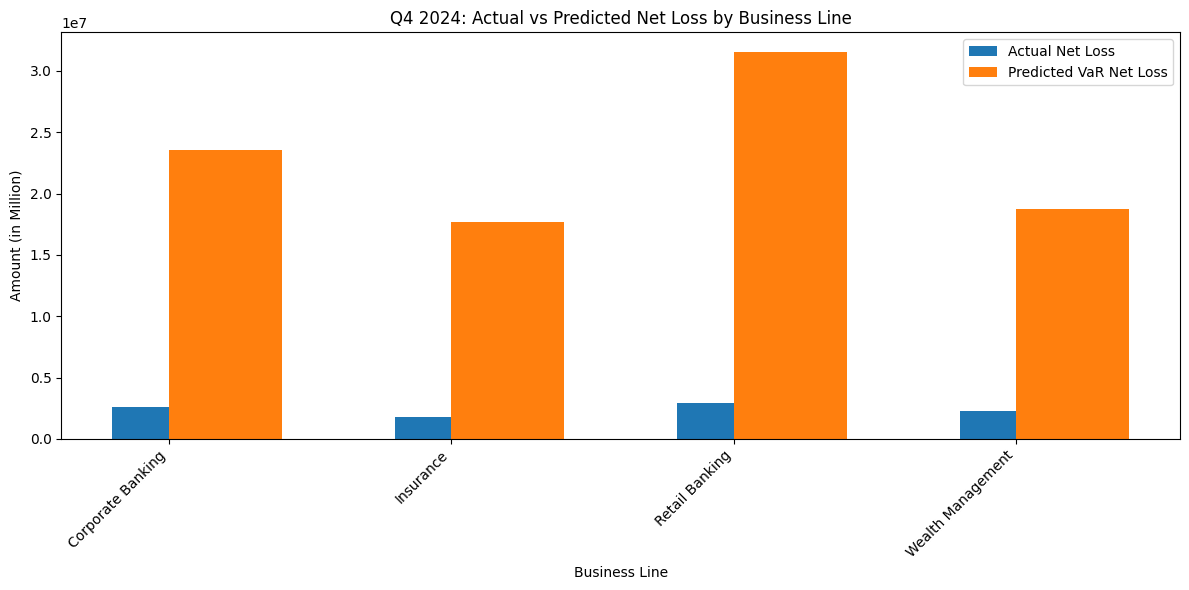

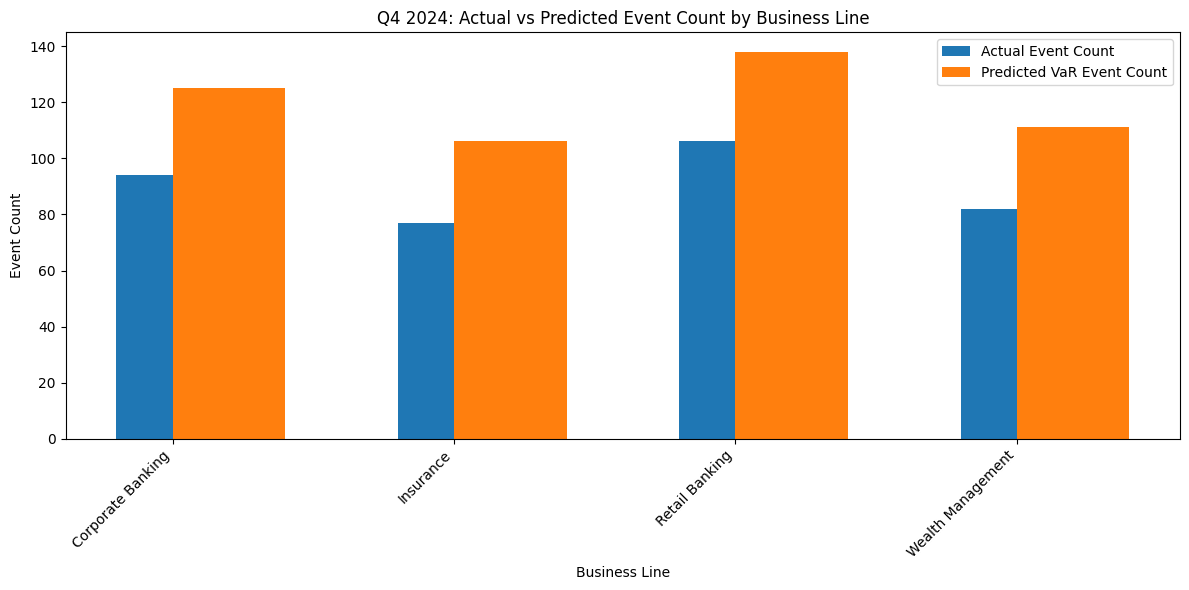

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, lognorm

# Assuming the previous code to calculate Var and get q4_2024_comparison_df

# Bar Plot for Comparison of Actual vs Predicted Net Loss
plt.figure(figsize=(12, 6))
plt.bar(q4_2024_comparison_df['Business Line'], q4_2024_comparison_df['Actual Net Loss'], width=0.4, label='Actual Net Loss', align='center')
plt.bar(q4_2024_comparison_df['Business Line'], q4_2024_comparison_df['Predicted VaR Net Loss'], width=0.4, label='Predicted VaR Net Loss', align='edge')
plt.xlabel('Business Line')
plt.ylabel('Amount (in Million)')
plt.title('Q4 2024: Actual vs Predicted Net Loss by Business Line')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Bar Plot for Comparison of Actual vs Predicted Event Count
plt.figure(figsize=(12, 6))
plt.bar(q4_2024_comparison_df['Business Line'], q4_2024_comparison_df['Actual Event Count'], width=0.4, label='Actual Event Count', align='center')
plt.bar(q4_2024_comparison_df['Business Line'], q4_2024_comparison_df['Predicted VaR Event Count'], width=0.4, label='Predicted VaR Event Count', align='edge')
plt.xlabel('Business Line')
plt.ylabel('Event Count')
plt.title('Q4 2024: Actual vs Predicted Event Count by Business Line')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


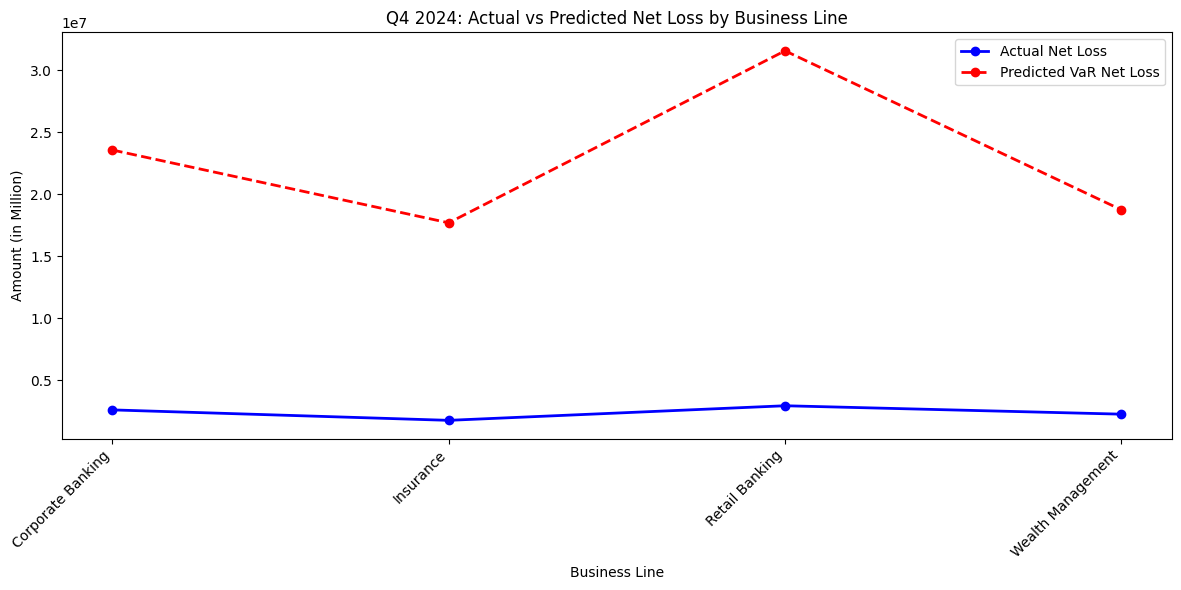

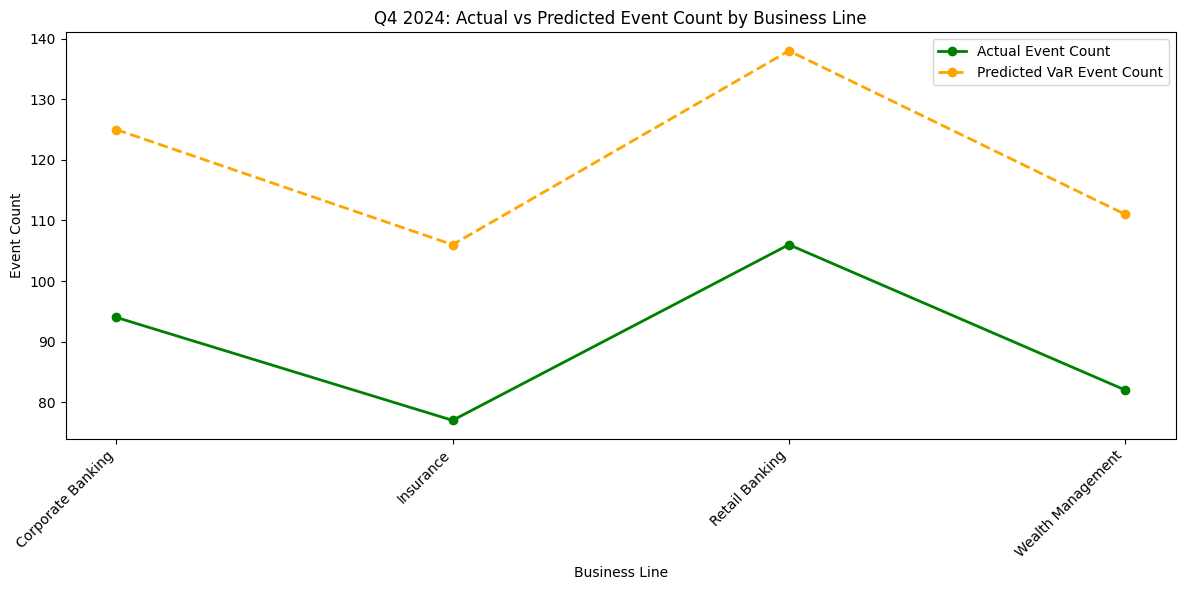

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming q4_2024_comparison_df already contains the necessary data for Actual vs Predicted

# Line Plot for Comparison of Actual vs Predicted Net Loss
plt.figure(figsize=(12, 6))
plt.plot(q4_2024_comparison_df['Business Line'], q4_2024_comparison_df['Actual Net Loss'], marker='o', label='Actual Net Loss', color='b', linestyle='-', linewidth=2)
plt.plot(q4_2024_comparison_df['Business Line'], q4_2024_comparison_df['Predicted VaR Net Loss'], marker='o', label='Predicted VaR Net Loss', color='r', linestyle='--', linewidth=2)
plt.xlabel('Business Line')
plt.ylabel('Amount (in Million)')
plt.title('Q4 2024: Actual vs Predicted Net Loss by Business Line')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Line Plot for Comparison of Actual vs Predicted Event Count
plt.figure(figsize=(12, 6))
plt.plot(q4_2024_comparison_df['Business Line'], q4_2024_comparison_df['Actual Event Count'], marker='o', label='Actual Event Count', color='g', linestyle='-', linewidth=2)
plt.plot(q4_2024_comparison_df['Business Line'], q4_2024_comparison_df['Predicted VaR Event Count'], marker='o', label='Predicted VaR Event Count', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Business Line')
plt.ylabel('Event Count')
plt.title('Q4 2024: Actual vs Predicted Event Count by Business Line')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
